<a href="https://colab.research.google.com/github/mersalas/MLBS-2025_workshop/blob/main/Lab_1b_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [ ]:
# Install packages
!pip install ucimlrepo
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.7 MB/s eta 0:00:00


In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from skopt import BayesSearchCV
from skopt.plots import plot_objective
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## **Load dataset**

In [ ]:
# Fetch dataset
from ucimlrepo import fetch_ucirepo
abalone = fetch_ucirepo(id=1)

## **Exploratory data analysis**

In [ ]:
# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets
X.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [ ]:
# Add y into X dataset
data = X.copy()
data['Rings'] = y
data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
# Metadata
print(abalone.metadata)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [ ]:
# Variable information
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

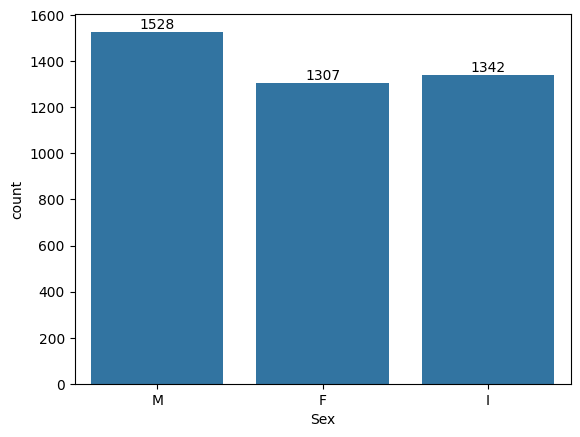

In [ ]:
# Countplot for variable sex
ax = sns.countplot(x='Sex', data=data)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
# Convert categorical into numerical values
label = LabelEncoder()
data['Sex'] = label.fit_transform(data['Sex'])

In [ ]:
# Check datatypes & if there are missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   int64  
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


In [ ]:
# summary statistics
data.describe()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,1.052909,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.822240,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
# How many samples have zero (0) values for height?
(data.Height == 0).sum()

np.int64(2)

In [ ]:
# Identify the samples with height = 0
data[data['Height'] == 0]

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
1257,1,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,1,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [ ]:
# Drop samples with height = 0
data = data[data['Height'] != 0]
data.describe()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4175.000000,4175.000000,4175.00000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000,4175.000000
mean,1.052934,0.524065,0.40794,0.139583,0.829005,0.359476,0.180653,0.238834,9.935090
std,0.822437,0.120069,0.09922,0.041725,0.490349,0.221954,0.109605,0.139212,3.224227
min,0.000000,0.075000,0.05500,0.010000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.35000,0.115000,0.442250,0.186250,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.42500,0.140000,0.800000,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.48000,0.165000,1.153500,0.502000,0.253000,0.328750,11.000000
max,2.000000,0.815000,0.65000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [ ]:
# Convert rings to the age of abalone
data['Age'] = data['Rings'] + 1.5

# Remove rings column
data = data.drop('Rings', axis=1)

data.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,2,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,2,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,2,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


<Axes: >

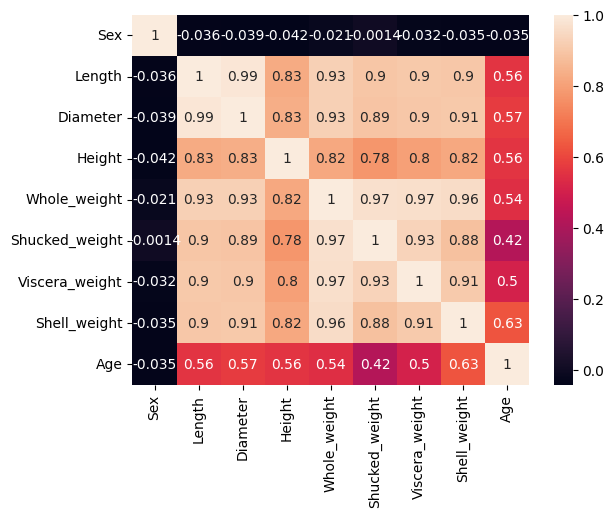

In [ ]:
# Correlation matrix
sns.heatmap(data.corr(), annot=True)

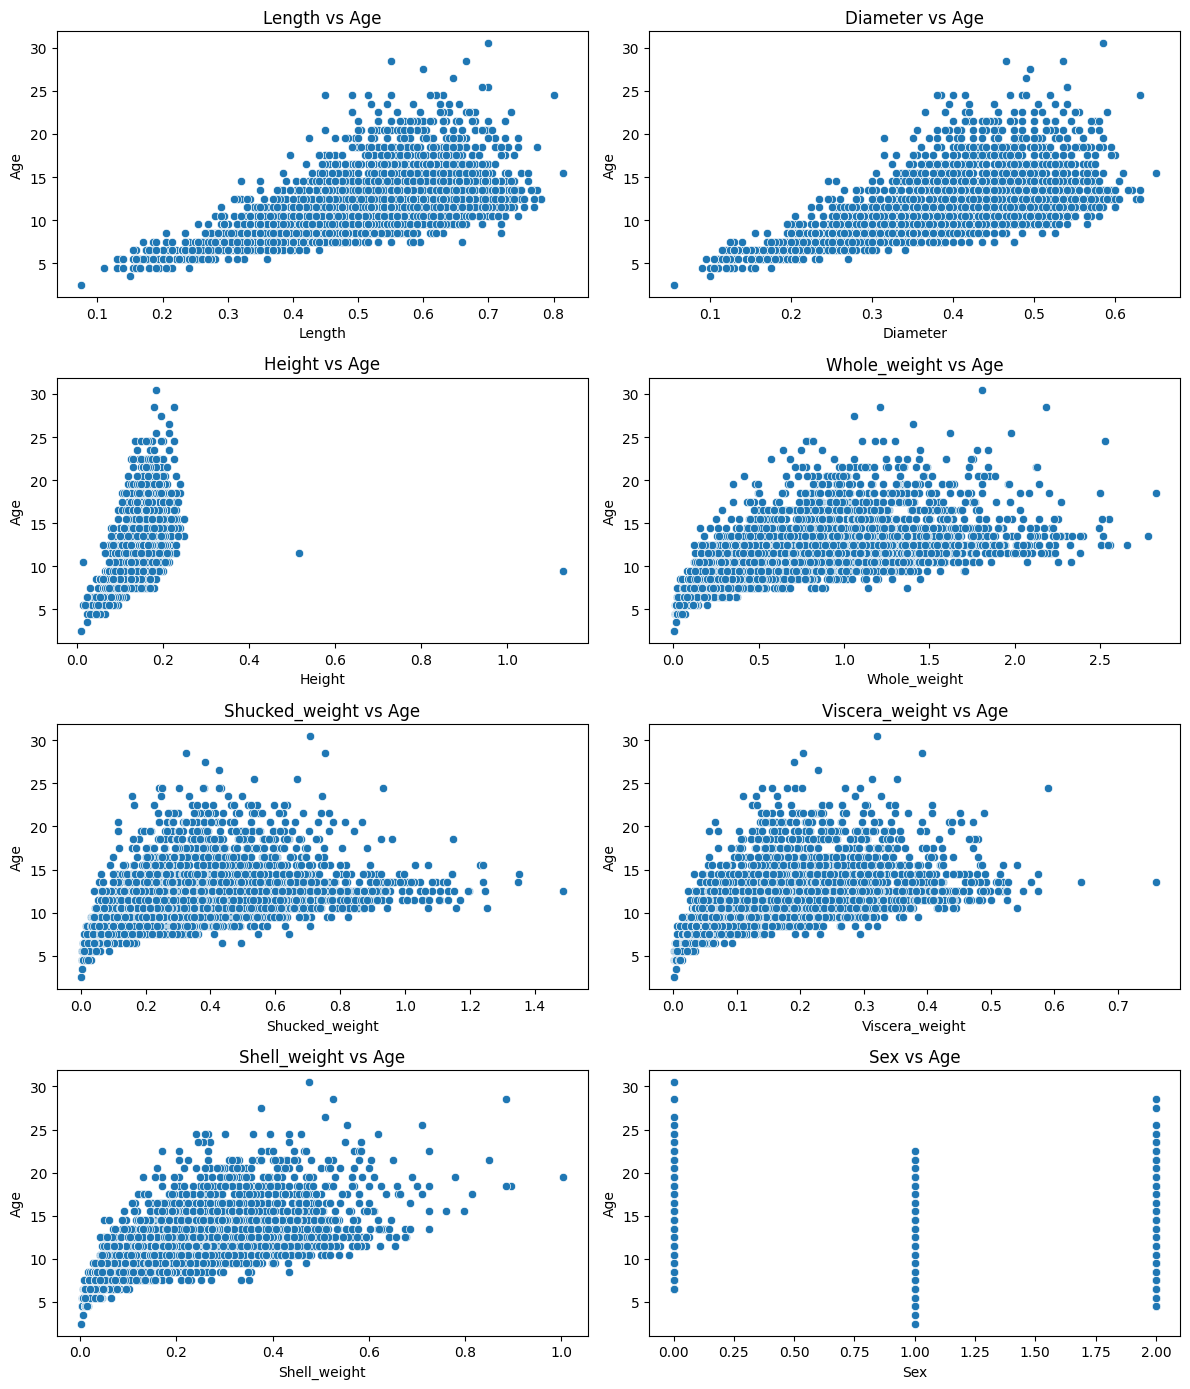

In [ ]:
# Scatter plot

# Define numeric features
numeric_features = ['Length', 'Diameter', 'Height', 'Whole_weight',
                    'Shucked_weight', 'Viscera_weight', 'Shell_weight', 'Sex']

# Create subplots
fig, axes = plt.subplots(4,2, figsize=(12,14))
axes = axes.flatten()

# Plot scatter plots for each numeric feature against age
for i, feature in enumerate(numeric_features):
  sns.scatterplot(data=data, x=feature, y='Age', ax=axes[i])
  axes[i].set_title(f"{feature} vs Age")
  axes[i].set_xlabel(feature)
  axes[i].set_ylabel('Age')

plt.tight_layout()
plt.show()

In [ ]:
# Separating the features from the target
X = data.iloc[:,0:8].values
y = data['Age'].values

<ipython-input-25-0f415a98584e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)


<Axes: ylabel='Density'>

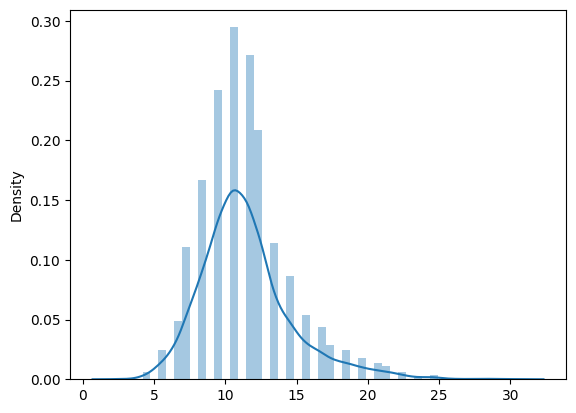

In [ ]:
# Target distribution
sns.distplot(y)

<Axes: >

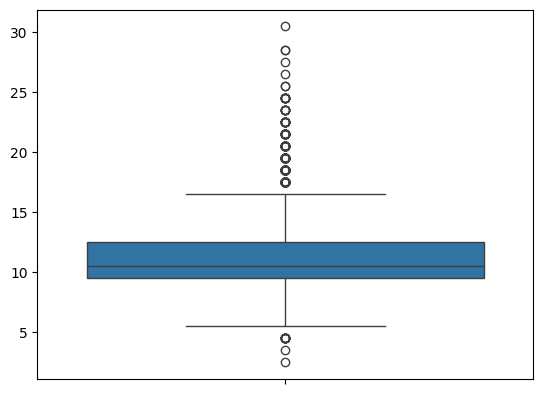

In [ ]:
# Box plot to detect outliers
sns.boxplot(y)

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
X_scale = scaler.fit_transform(X)

In [ ]:
# Split dataset into training & test set
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.20, random_state=42)

print("Size of training set: {}   Size of test set:"
      " {}\n".format(X_train.shape[0], X_test.shape[0]))

Size of training set: 3340   SIZE OF TEST SET: 835



## **Train model**

### Ridge regression

In [ ]:
# Perform Bayesian search to find optimum parameters for ridge
ridge = Ridge(random_state=42)

param = {'alpha': (1e-3, 1e1, 'log-uniform')}

cv = KFold(n_splits=10, shuffle=True, random_state=42)
ridge_cv = BayesSearchCV(estimator=ridge, search_spaces=param, cv=cv, scoring='r2',
                       n_jobs=-1, random_state=42)
ridge_cv.fit(X_train, y_train)

print('best parameters: ', ridge_cv.best_params_)
print('best score after search cv:', ridge_cv.best_score_)

best parameters:  OrderedDict([('alpha', 0.4312524444079454)])
best score after search cv: 0.5073109769984019


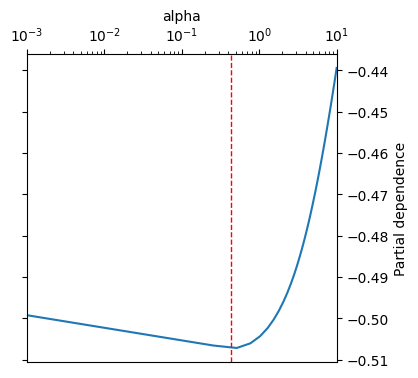

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(4,4))
plot_objective(ridge_cv.optimizer_results_[0], ax=ax)
plt.show()

In [ ]:
# Train ridge
ridge_tuned = Ridge(**ridge_cv.best_params_, random_state=42)

ridge_tuned.fit(X_train, y_train)

Ridge(alpha=0.4312524444079454, random_state=42)

In [ ]:
# Print intercept & coefficients
print('intercept:', ridge_tuned.intercept_ )
print('coef:', ridge_tuned.coef_, end='\n')

intercept: 5.26843014989778
coef: [  0.14126334  -0.74207172   7.70883395  10.2032003   13.79275894
 -22.86572655  -3.2041107   12.7228444 ]


In [ ]:
# Evaluate the ridge model on the training set
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(ridge_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the ridge model on the training set:\nR2: {:.4f}\nMSE: {:.4f}\nMAE: {:.4f}".format(
    np.mean(cv_results['test_r2']),
    np.mean(cv_results['test_neg_mean_squared_error']),
    np.mean(cv_results['test_neg_mean_absolute_error'])
))

Performance of the ridge model on the training set:
R2: 0.5097
MSE: -4.9710
MAE: -1.6126


### Lasso regression

In [ ]:
# Perform Bayesian search to find optimum parameters for lasso
lasso = Lasso(random_state=42)

param = {'alpha': (1e-3, 1, 'log-uniform')}

cv = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_cv = BayesSearchCV(estimator=lasso, search_spaces=param, cv=cv, scoring='r2',
                       n_jobs=-1, random_state=42)
lasso_cv.fit(X_train, y_train)

print('best parameters: ', lasso_cv.best_params_)
print('best score after search cv:', lasso_cv.best_score_)

best parameters:  OrderedDict([('alpha', 0.0018846559676118995)])
best score after search cv: 0.5041530861223678


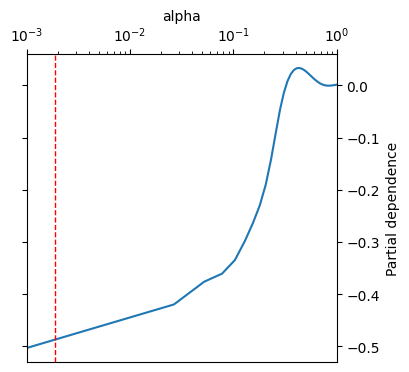

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(4,4))
plot_objective(lasso_cv.optimizer_results_[0], ax=ax)
plt.show()

In [ ]:
# Train lasso
lasso_tuned = Lasso(**lasso_cv.best_params_, random_state=42)

lasso_tuned.fit(X_train, y_train)

Lasso(alpha=0.0018846559676118995, random_state=42)

In [ ]:
# Print intercept & coefficients
print('intercept:', lasso_tuned.intercept_ )
print('coef:', lasso_tuned.coef_, end='\n')

intercept: 5.334523411651647
coef: [  0.13624399   0.           6.95666439   9.0112207   14.11616579
 -23.77963893  -2.18992216  12.53418904]


In [ ]:
# Evaluate the lasso model on the training set
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(lasso_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the lasso model on the training set:\nR2: {:.4f}\nMSE: {:.4f}\nMAE: {:.4f}".format(
    np.mean(cv_results['test_r2']),
    np.mean(cv_results['test_neg_mean_squared_error']),
    np.mean(cv_results['test_neg_mean_absolute_error'])
))

Performance of the lasso model on the training set:
R2: 0.5080
MSE: -4.9892
MAE: -1.6136


### ElasticNet regression

In [ ]:
# Perform Bayesian search to find optimum parameters for elasticnet
enet = ElasticNet(random_state=42)

param = {'alpha': (1e-3, 1, 'log-uniform'),
         'l1_ratio': (0,1)}

cv = KFold(n_splits=10, shuffle=True, random_state=42)
enet_cv = BayesSearchCV(estimator=enet, search_spaces=param, cv=cv, scoring='r2',
                       n_jobs=-1, random_state=42)
enet_cv.fit(X_train, y_train)

print('best parameters: ', enet_cv.best_params_)
print('best score after search cv:', enet_cv.best_score_)

best parameters:  OrderedDict([('alpha', 0.0018869193492104424), ('l1_ratio', 1)])
best score after search cv: 0.5041530737350329


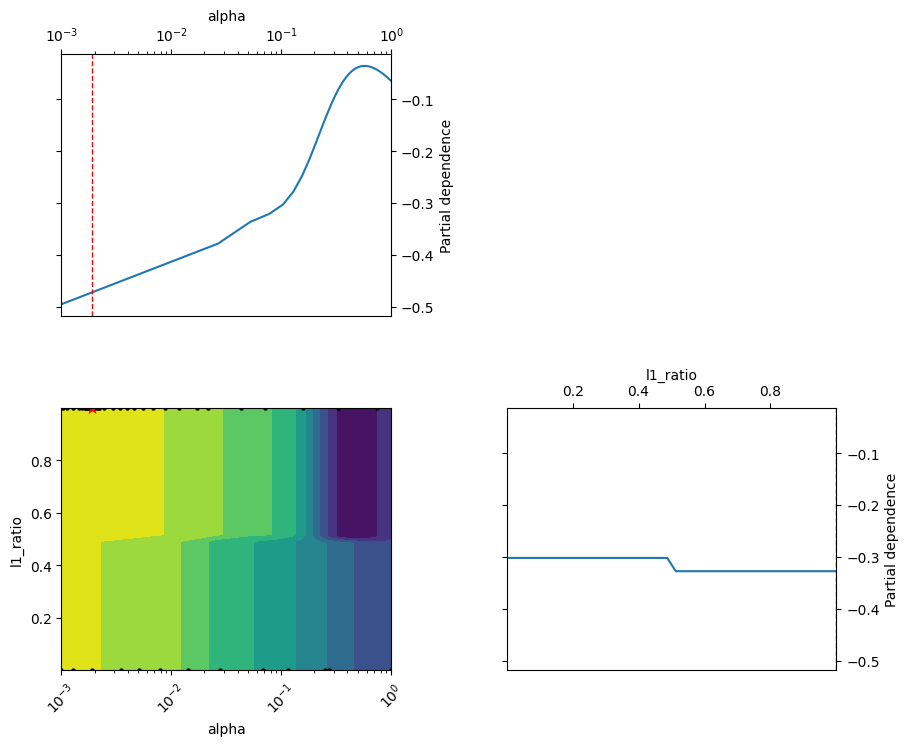

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10,8))
plot_objective(enet_cv.optimizer_results_[0], ax=ax)
plt.show()

In [ ]:
# Train enet
enet_tuned = ElasticNet(**enet_cv.best_params_, random_state=42)

enet_tuned.fit(X_train, y_train)

ElasticNet(alpha=0.0018869193492104424, l1_ratio=1, random_state=42)

In [ ]:
# Print intercept & coefficients
print('intercept:', enet_tuned.intercept_ )
print('coef:', enet_tuned.coef_, end='\n')

intercept: 5.334833257410397
coef: [  0.13621419   0.           6.95653192   9.00695529  14.1055122
 -23.7738613   -2.18554089  12.5382773 ]


In [ ]:
# Evaluate the enet model on the training set
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(enet_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the enet model on the training set:\nR2: {:.4f}\nMSE: {:.4f}\nMAE: {:.4f}".format(
    np.mean(cv_results['test_r2']),
    np.mean(cv_results['test_neg_mean_squared_error']),
    np.mean(cv_results['test_neg_mean_absolute_error'])
))

Performance of the enet model on the training set:
R2: 0.5080
MSE: -4.9892
MAE: -1.6136


### KNR

In [ ]:
# Perform random search to find the optimum parameters for KNR
knr = KNeighborsRegressor(n_jobs=-1)

param = {'n_neighbors': (5, 20),
         'weights': ['uniform', 'distance'],
         'p': (1,2,3),
         'metric': ['minkowski', 'manhattan', 'euclidean']
         }

cv = KFold(n_splits=10, shuffle=True, random_state=42)
knr_cv = BayesSearchCV(estimator=knr, search_spaces=param, cv=cv, scoring='r2',
                       n_jobs=-1, random_state=42)

knr_cv.fit(X_train, y_train)

print('best parameters: ', knr_cv.best_params_)
print('best score after random search cv:', knr_cv.best_score_)

best parameters:  OrderedDict([('metric', 'euclidean'), ('n_neighbors', 18), ('p', 1), ('weights', 'distance')])
best score after random search cv: 0.5276362162544299


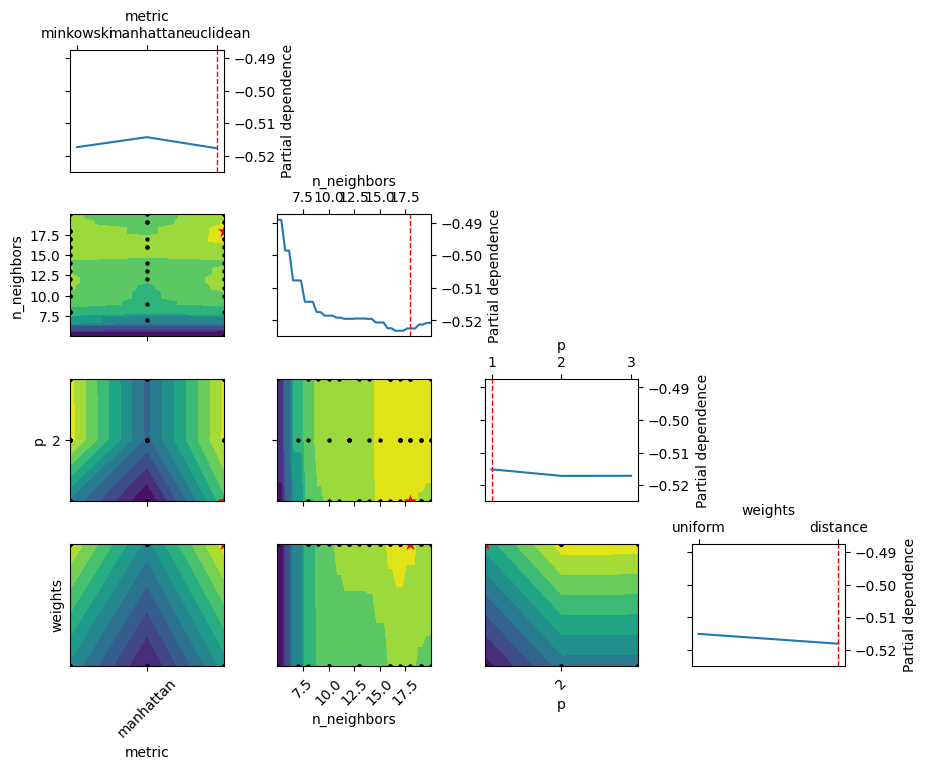

In [ ]:
# Plot the Bayesian objective function
fig, ax = plt.subplots(figsize=(10,8))
plot_objective(knr_cv.optimizer_results_[0], ax=ax)
plt.show()

In [ ]:
# Train KNR
knr_tuned = KNeighborsRegressor(n_neighbors=17, weights='distance', p=2,
                                 metric='euclidean', n_jobs=-1)

knr_tuned.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_jobs=-1, n_neighbors=17,
                    weights='distance')

In [ ]:
# Evaluate the KNR model on the training set
scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
cv_results = cross_validate(knr_tuned, X_train, y_train, cv=10, scoring=scoring, n_jobs=-1)

print("Performance of the enet model on the training set:\nR2: {:.4f}\nMSE: {:.4f}\nMAE: {:.4f}".format(
    np.mean(cv_results['test_r2']),
    np.mean(cv_results['test_neg_mean_squared_error']),
    np.mean(cv_results['test_neg_mean_absolute_error'])
))

Performance of the enet model on the training set:
R2: 0.5280
MSE: -4.7910
MAE: -1.5166


## **Evaluation**

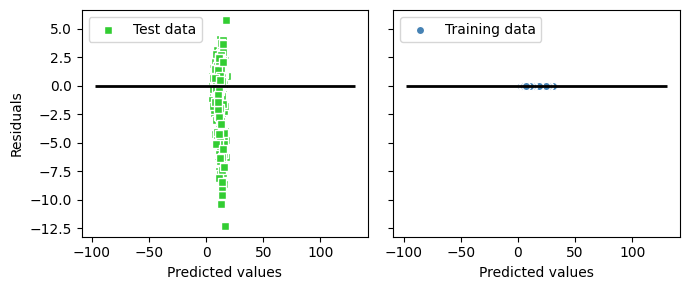

In [ ]:
# Residual plot
y_train_pred = knr_tuned.predict(X_train)
y_test_pred = knr_tuned.predict(X_test)

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), sharey=True)

ax1.scatter(
    y_test_pred, y_test_pred - y_test,
    c='limegreen', marker='s',
    edgecolor='white', label='Test data')

ax2.scatter(
    y_train_pred, y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
  ax.set_xlabel('Predicted values')
  ax.legend(loc='upper left')
  ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,\
            color='black', lw=2)

plt.tight_layout()
plt.show()

In [ ]:
y_pred_knr = knr_tuned.predict(X_test)

print("Performance of the KNR model on the test set:")
print("R2: {:.4f}".format(r2_score(y_test, y_pred_knr)))
print("MSE: {:.4f}".format(mean_squared_error(y_test, y_pred_knr)))
print("MAE: {:.4f}".format(mean_absolute_error(y_test, y_pred_knr)))

Performance of the KNR model on the test set:
R2: 0.5453
MSE: 5.1884
MAE: 1.5587


## **Exercise 1b**

Using the abalone dataset, build regressor using the following algorithms:


*   SVR
*   RandomForestRegressor



